In [149]:
%matplotlib inline
import pandas as pd
import spotipy
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
import plotly.express as px
from datetime import datetime
import time
import re
import os

In [195]:
streaming_history_files = ['StreamingHistory0.json','StreamingHistory1.json', 
                           'StreamingHistory2.json', 'StreamingHistory3.json']
user_timezone = 'US/Eastern'
track_features_fn = 'track_features_peter.csv'
artists_fn = 'artists_peter.csv'
genres_fn = 'genres_peter.csv'
sh_fn = 'streaming_history_peter.csv'

# streaming_history_files = ['StreamingHistory0_public.json']
# user_timezone = 'America/Los_Angeles' # User who uploaded it is from Seattle
# track_features_fn = 'track_features_public.csv'
# artists_fn = 'artists_public.csv'
# genres_fn = 'genres_public.csv'
# sh_fn = 'streaming_history_public.csv'

## Load and append each streaming history file

In [196]:
sh = pd.read_json(streaming_history_files[0])
for i in range(1,len(streaming_history_files)):
    t = pd.read_json(streaming_history_files[i])
    sh = pd.concat((sh, t))
print('Number of listens (w/ duplicates): ', len(sh))
sh.sort_values('endTime', ascending=False).head(3)

Number of listens (w/ duplicates):  33094


,endTime,artistName,trackName,msPlayed
6786,2020-10-07 22:47,Gábor Szabó,San Franciscan Nights,955
6785,2020-10-07 22:47,Belle & Sebastian,Your Cover's Blown,361786
6784,2020-10-07 22:47,Dehd,Lucky,1505


## Remove any duplicates

In [197]:
sh.drop_duplicates(inplace=True)
print('Number of listens after removing duplicates: ', len(sh))

Number of listens after removing duplicates:  30646


## Process the data

new columns for day of week and such

In [198]:
# Get the endTime into date format, then convert to the user's local timezone
sh['endTime'] = pd.to_datetime(sh['endTime'])

sh['endTime_utc'] = sh['endTime'].dt.tz_localize('UTC')
sh['endTime_loc'] = sh['endTime_utc'].dt.tz_convert(user_timezone)

In [199]:
sh['day_of_week'] = sh['endTime_loc'].dt.day_name()
sh['weekday'] = ((sh['endTime_loc'].dt.dayofweek) // 5 == 1).astype(int)
sh['season_num'] = (sh['endTime_loc'].dt.month%12 + 3)//3
sh['season'] = ''
sh.loc[sh['season_num'] == 1,'season'] = 'winter'
sh.loc[sh['season_num'] == 2,'season'] = 'spring'
sh.loc[sh['season_num'] == 3,'season'] = 'summer'
sh.loc[sh['season_num'] == 4,'season'] = 'fall'
sh['hour_of_day'] = sh['endTime_loc'].dt.hour
sh.head()

,endTime,artistName,trackName,msPlayed,endTime_utc,endTime_loc,day_of_week,weekday,season_num,season,hour_of_day
0,2018-01-30 23:06:00,Jay Som,Peach Boy,62226,2018-01-30 23:06:00+00:00,2018-01-30 18:06:00-05:00,Tuesday,0,1,winter,18
1,2018-12-06 22:20:00,Dr. Dog,Mystery To Me,123992,2018-12-06 22:20:00+00:00,2018-12-06 17:20:00-05:00,Thursday,0,1,winter,17
2,2018-12-07 02:52:00,Dr. Dog,Mystery To Me,138140,2018-12-07 02:52:00+00:00,2018-12-06 21:52:00-05:00,Thursday,0,1,winter,21
3,2018-12-07 14:37:00,Bad Travel Podcast,"Episode 2: Chiang Mai, Thailand",1648441,2018-12-07 14:37:00+00:00,2018-12-07 09:37:00-05:00,Friday,0,1,winter,9
4,2018-12-07 18:25:00,Sunny Day Real Estate,In Circles - Remastered,96130,2018-12-07 18:25:00+00:00,2018-12-07 13:25:00-05:00,Friday,0,1,winter,13


In [141]:
# Save the data to CSV
sh.to_csv(sh_fn, index=False)

## Get a sense of the data

In [142]:
print('Earliest date: ', sh['endTime'].min())
print('Latest date: ', sh['endTime'].max())
print('Num Unique Artist: ', sh['artistName'].nunique())
print('Num Unique Tracks: ', sh.groupby(['artistName','trackName']).ngroups)

Earliest date:  2019-02-13 06:25:00
Latest date:  2020-02-08 21:52:00
Num Unique Artist:  818
Num Unique Tracks:  1482


In [144]:
fig = px.histogram(sh, x="endTime", y="msPlayed")
fig.show()

In [145]:
fig = px.histogram(sh, x="hour_of_day", y="msPlayed")
fig.show()

In [146]:
tracks = sh.groupby(['artistName', 'trackName'], as_index=False)[['artistName', 'trackName']].size().reset_index(name='n_listens')
tracks.sort_values('n_listens', ascending=False).head(3)

,artistName,trackName,n_listens
871,Mondo Grosso,ラビリンス,23
179,Calvin Harris,Bounce (feat. Kelis) - Radio Edit,22
370,Drake,Madiba Riddim,22


In [147]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="8e78672ecefa44e58dd8a0b1af9a4fd1",
                                                           client_secret="f48a74f4d6da4312b37f2f7808c08443"))

In [150]:
# If track_features already exists, load it, else create it from tracks
if os.path.exists(track_features_fn):
    track_features = pd.from_csv(track_features_fn)
else:
    track_features = tracks.copy()

    spotify_track_features = ['album', 'album_release_date', 'album_type', 'explicit', 'popularity', 'preview_url', 'artists']
    spotify_features = ['danceability', 'energy', 'key', 'loudness', 'mode',
                        'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                        'valence', 'tempo', 'duration_ms', 'time_signature']

    track_features['spotify_id'] = None
    track_features[spotify_features] = pd.DataFrame([[np.nan,]*len(spotify_features)], index=track_features.index)
    track_features[spotify_track_features] = pd.DataFrame([[None]*len(spotify_track_features)], index=track_features.index)

In [151]:
start = time.time()

for i in range(len(track_features)):
    if track_features['spotify_id'].iloc[i] is not None: continue

    artist_name = track_features.iloc[i]['artistName']
    track_name = track_features.iloc[i]['trackName']
    
    if (artist_name == 'Unknown Artist' or track_name == 'Unknown Track'): continue

    try:
        results = sp.search(q='artist:' + artist_name + ' track:' + track_name, limit=1, type='track')
        if results is None or len(results) == 0 or len(results['tracks']['items']) == 0:
            # Remove text inside parentheses/brackets and try again
            results = sp.search(q='artist:' + re.sub("[\(\[].*?[\)\]]", "", artist_name) + ' track:' + re.sub("[\(\[].*?[\)\]]", "", track_name), limit=1, type='track')
            if results is None or len(results) == 0 or len(results['tracks']['items']) == 0:
                # Try again with just the track name
                results = sp.search(q=' track:' + re.sub("[\(\[].*?[\)\]]", "", track_name), limit=1, type='track')
                if results is None or len(results) == 0 or len(results['tracks']['items']) == 0:
                    # Try again without any special characters
                    results = sp.search(q='artist:' + re.sub(r'[^A-Za-z0-9 ]+', '', artist_name) + ' track:' + re.sub(r'[^A-Za-z0-9 ]+', '', track_name), limit=1, type='track')
                    #if results is None or len(results) == 0 or len(results['tracks']['items']) == 0:
                    #    print('artist:' + artist_name + ' track:' + track_name, results, sep="\n")

        spotify_id = results['tracks']['items'][0]['id']
        track_features['spotify_id'].iloc[i] = spotify_id

        features = sp.audio_features(tracks=[spotify_id])
        if (len(features) > 1): print('Features is > 1. Why?', features)

        for feat in spotify_features:
            track_features[feat].iloc[i] = features[0][feat]

        spotify_track = sp.track(spotify_id)

        track_features['album'].iloc[i] = spotify_track['album']['name']
        track_features['artists'].iloc[i] = ', '.join([artist['name'] for artist in spotify_track['artists']])
        track_features['explicit'].iloc[i] = spotify_track['explicit']
        track_features['popularity'].iloc[i] = spotify_track['popularity']
        track_features['preview_url'].iloc[i] = spotify_track['preview_url']
        track_features['album_release_date'].iloc[i] = spotify_track['album']['release_date']
        track_features['album_type'].iloc[i] = spotify_track['album']['album_type']
    except:
        # print('Exception', results)
        pass

    if (i+1) % 500 == 0:
        # Cache the file in case something happens
        track_features.to_csv('track_features{}.csv'.format(datetime.today().strftime('%Y-%m-%d')), index=False)
        print(i+1, '\tof ', len(track_features),' completed.\t', int(((time.time()-start)/(i+1))*(len(track_features)-i)), 's remaining', sep='')

track_features.to_csv(track_features_fn, index=False)

C:\Program Files\Python36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



500	of 1482 completed.	294s remaining
1000	of 1482 completed.	145s remaining


## Explore the new features a bit

In [155]:
track_features.head()

,artistName,trackName,n_listens,spotify_id,danceability,energy,key,loudness,mode,speechiness,...,tempo,duration_ms,time_signature,album,album_release_date,album_type,explicit,popularity,preview_url,artists
0,((( O ))),Higher,1,0Rtf1PWeXnQLsFFyOcQrnk,0.532,0.490,10.0,-5.575,0.0,0.0732,...,138.806,237875.0,4.0,((( ~ ))),2019-04-05,single,False,42,https://p.scdn.co/mp3-preview/381166ba07c58606...,((( O )))
1,(dc),De Nada (Vocal Edit),1,7nhSO9GYru1AYREmIq2Too,0.764,0.703,11.0,-5.623,0.0,0.3510,...,119.948,168229.0,4.0,De Nada,2015-05-14,single,False,40,https://p.scdn.co/mp3-preview/97e47517f0005521...,"(dc), Masego"
2,21 Savage,Ghostface Killers,1,5u6vkDnOyaf8LsteDAj2ub,0.782,0.436,2.0,-7.033,1.0,0.1550,...,82.994,268933.0,4.0,Without Warning,2017-10-30,album,True,72,https://p.scdn.co/mp3-preview/e1b26f13f5344938...,"21 Savage, Offset, Metro Boomin, Travis Scott"
3,21 Savage,a lot,20,2t8yVaLvJ0RenpXUIAC52d,0.837,0.636,1.0,-7.643,1.0,0.0860,...,145.972,288624.0,4.0,i am > i was,2018-12-21,album,True,79,https://p.scdn.co/mp3-preview/0ff1fadf009e81e7...,21 Savage
4,21 Savage,monster,1,2FUNBaa5DwItJtYEBgAblU,0.890,0.607,9.0,-6.916,0.0,0.1240,...,134.022,233040.0,4.0,i am > i was,2018-12-21,album,True,66,https://p.scdn.co/mp3-preview/77673ecb9ddb7745...,21 Savage


In [156]:
fig = px.histogram(track_features, x="album_release_date", y='n_listens')
fig.show()

In [157]:
fig = px.histogram(track_features, x="danceability")
fig.show()

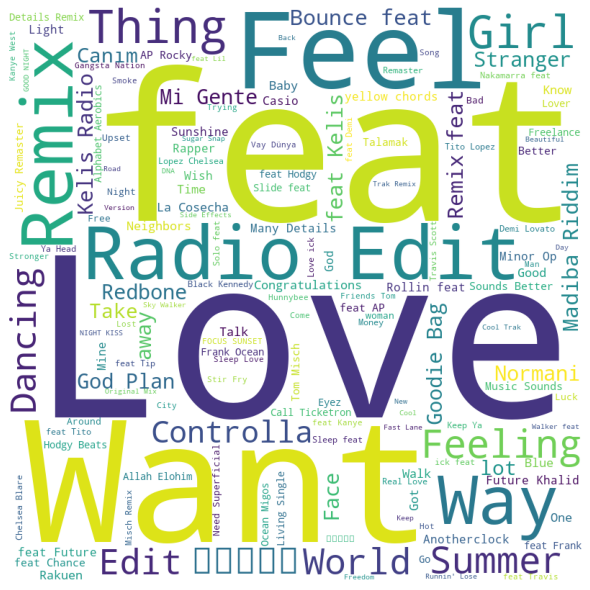

In [160]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

words_in_titles = " ".join(sh['trackName'].values)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(words_in_titles) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

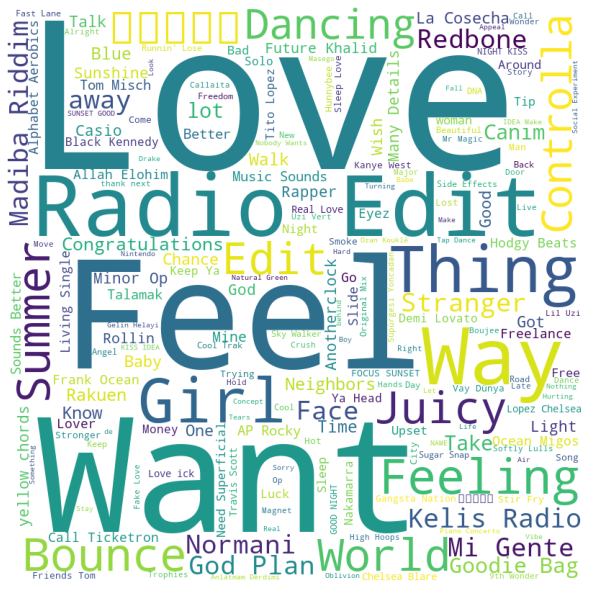

In [161]:
# Add some more stop words
stopwords = set(STOPWORDS)

words_in_titles = " ".join(sh['trackName'].values)+" "

stopwords.update(['feat', 'Remix', 'Remastered', 'Remaster', 'Version'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words_in_titles) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Get artist & genre information

In [201]:
artists = sh.groupby(['artistName'], as_index=False)[['artistName']].size().reset_index(name='n_listens')

artists['spotify_id'], artists['genres'], artists['spotify_artist_name'] = None, None, None
artists[['n_followers', 'popularity']] = pd.DataFrame([[np.nan,]*2], index=artists.index)

print('Most listened to artists. Will fill in columns next')
artists.sort_values('n_listens', ascending=False).head(5)

Most listened to artists. Will fill in columns next


,artistName,n_listens,spotify_id,genres,spotify_artist_name,n_followers,popularity
1143,Kanye West,885,None,None,None,NaN,NaN
2551,of Montreal,634,None,None,None,NaN,NaN
151,BROCKHAMPTON,533,None,None,None,NaN,NaN
1328,Mac Miller,495,None,None,None,NaN,NaN
1604,Pavement,401,None,None,None,NaN,NaN


In [202]:
start = time.time()

genre = {'artistName':[], 'genre':[]}

for i in range(len(artists)):
    if artists['spotify_id'].iloc[i] is not None: continue

    artist_name = artists.iloc[i]['artistName']
    
    if (artist_name == 'Unknown Artist'): continue

    try:
        results = sp.search(q='artist:' + artist_name, limit=1, type='artist')
        if results is None or len(results) == 0 or len(results['artists']['items']) == 0:
            # Remove text inside parentheses/brackets and try again
            results = sp.search(q='artist:' + re.sub("[\(\[].*?[\)\]]", "", artist_name), limit=1, type='artist')
            if results is None or len(results) == 0 or len(results['artists']['items']) == 0:
                # Try again without any special characters
                results = sp.search(q='artist:' + re.sub(r'[^A-Za-z0-9 ]+', '', artist_name), limit=1, type='artist')
                if results is None or len(results) == 0 or len(results['artists']['items']) == 0:
                    print('Couldn\'t get info for artist:' + artist_name, sep="\n")
                    continue

        r = results['artists']['items'][0]
        
        artists['spotify_id'].iloc[i] = r['id']
        artists['genres'].iloc[i] = str(r['genres'])
        artists['spotify_artist_name'].iloc[i] = r['name']
        artists['n_followers'].iloc[i] = r['followers']['total']
        artists['popularity'].iloc[i] = r['popularity']
        
        for g in r['genres']:
            genre['artistName'].append(artist_name)
            genre['genre'].append(g)
    except:
        print('Exception', results)
        pass

    if (i+1) % 500 == 0:
        # Cache the file in case something happens
        artists.to_csv('artists{}.csv'.format(datetime.today().strftime('%Y-%m-%d')), index=False)
        print(i+1, '\tof ', len(artists),' completed.\t', int(((time.time()-start)/(i+1))*(len(artists)-i)), 's remaining', sep='')

artists.to_csv(artists_fn, index=False)
genre_df = pd.DataFrame(genre)
genre_df.to_csv(genres_fn, index=False)

C:\Program Files\Python36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Couldn't get info for artist:Artificial Intelligence (AI Podcast) with Lex Fridman
Couldn't get info for artist:Axios Re:Cap
Couldn't get info for artist:Bad Travel Podcast
Couldn't get info for artist:Bravo TV's The Daily Dish
Couldn't get info for artist:Call Her Daddy
Couldn't get info for artist:Conspiracy Of Owls
500	of 2568 completed.	201s remaining
Couldn't get info for artist:Danger Doom
Couldn't get info for artist:Going Deep with Chad and JT
Couldn't get info for artist:Harmontown
1000	of 2568 completed.	156s remaining
Couldn't get info for artist:L'Impératrice
Couldn't get info for artist:Lexicon Valley
Couldn't get info for artist:Medslaus
Couldn't get info for artist:NPR News Now
1500	of 2568 completed.	105s remaining
Couldn't get info for artist:Oriental Sunshine
Couldn't get info for artist:Oysters, Clams & Cockles
Couldn't get info for artist:Paeya
Couldn't get info for artist:Post Reports
Couldn't get info for artist:Relatively Clean Rivers
Couldn't get info for artist

In [213]:
genre_grouped = genre_df.groupby(['genre'], as_index=False)[['genre']].size().reset_index(name='n_artists').sort_values('n_artists', ascending=False)
genre_grouped.head()

,genre,n_artists
542,indie rock,278
535,indie pop,216
507,hip hop,215
929,rap,198
952,rock,175


In [204]:
artists.sort_values('n_listens', ascending=False).head(5)

,artistName,n_listens,spotify_id,genres,spotify_artist_name,n_followers,popularity
1143,Kanye West,885,5K4W6rqBFWDnAN6FQUkS6x,"['chicago rap', 'rap']",Kanye West,12558110.0,92.0
2551,of Montreal,634,5xeBMeW0YzWIXSVzAxhM8O,"['alternative dance', 'alternative rock', 'ant...",of Montreal,237125.0,56.0
151,BROCKHAMPTON,533,1Bl6wpkWCQ4KVgnASpvzzA,"['boy band', 'hip hop', 'rap']",BROCKHAMPTON,1592930.0,79.0
1328,Mac Miller,495,4LLpKhyESsyAXpc4laK94U,"['hip hop', 'pittsburgh rap', 'pop rap', 'rap']",Mac Miller,4914903.0,87.0
1604,Pavement,401,3inCNiUr4R6XQ3W43s9Aqi,"['alternative pop', 'alternative rock', 'anti-...",Pavement,316720.0,62.0


In [205]:
fig = px.histogram(artists, x="popularity")
fig.show()

In [228]:
df = px.data.tips()
genre_grouped_temp = genre_grouped.copy()
top_genres = genre_grouped_temp.iloc[20]['n_artists']
genre_grouped_temp.loc[genre_grouped_temp['n_artists'] < top_genres, 'genre'] = 'Other genres' 
genre_grouped_temp = genre_grouped_temp.groupby('genre', as_index=False).sum()
fig = px.pie(genre_grouped_temp, values='n_artists', names='genre')
fig.show()
genre_grouped_temp.sort_values('n_artists', ascending=False)

,genre,n_artists
0,Other genres,7474
12,indie rock,278
11,indie pop,216
8,hip hop,215
16,rap,198
17,rock,175
3,art pop,169
6,freak folk,157
2,alternative rock,145
13,modern rock,141


In [208]:
print('Unpopular artists listened to')
artists.sort_values('popularity').head()

Very unpopular artists listened to


,artistName,n_listens,spotify_id,genres,spotify_artist_name,n_followers,popularity
968,ILLBLAST,1,6yRUxthDfSqLkhzbPDzrY1,[],ILLBLAST,6.0,0.0
818,Gelugpa Order,3,3qFHfvCGD0IyOOeLAXX6VX,[],Gelugpa Order,33.0,0.0
375,Charles Hussle,3,5grkYFW3uXsGs9PD05SYs6,[],Charles Hussle,35.0,0.0
1949,Ssunno,1,0AXQZqoL1pNsoftfLqvqYp,[],Ssunno,4.0,0.0
1261,Lil Balake,1,6MmF2vN4BwkoZSTnJn0E3l,[],Lil Balake,11.0,0.0
1668,Pshow,1,7fPhHQBp7kZGN1GdS7VdMx,[],Pshowpray,1.0,0.0
2450,Windfall,1,1XO3ww3undikxrzRAwKDsq,[],Windfall,9.0,0.0
1675,Purple Python,1,35vpr0Wyl41txVMSe3vVpZ,[],Purple Python,9.0,0.0
1063,Jess Tambellini,3,0fqwAAjS8Sz3pEriT7ZSTg,[],Jess Tambellini,4.0,0.0
1398,Michael Goldman,1,5BEaHpMWxE5Z6x7z1JioXN,[],Michael Goldman,9.0,0.0


In [229]:
fig = px.scatter(artists, x="n_listens", y="popularity", hover_data=['artistName'])
fig.show()

In [233]:
artists_temp = artists.copy()
artists_temp['log_n_listens'] = np.log(artists_temp['n_listens'])
fig = px.scatter(artists_temp, x="log_n_listens", y="popularity", hover_data=['artistName','n_listens'])
fig.show()